In [5]:
#import all the modules that we need for the analysis
from __future__ import print_function, absolute_import, division
#%matplotlib inline
%matplotlib inline
##imports
import os
import requests
import numpy as np
import pandas as pd
import seaborn as sb
import astropy.io.fits as pf
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

#froms from standards
import astropy
from glob import glob
from astropy.wcs import WCS
from astropy.io import fits
from matplotlib import cm
from scipy.signal import medfilt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FormatStrFormatter

#froms from non-standards
from astroquery.mast import Catalogs
from lightkurve import TessTargetPixelFile
#from tess_stars2px import tess_stars2px_function_entry
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from glob import glob

from numpy import exp, loadtxt, pi, sqrt
#from lmfit import Model
from matplotlib import rc
from astropy.modeling import models, fitting
import numpy as np
#import radvel

In [6]:
section_number = 0

In [7]:
import lightkurve as lk 

search_result = lk.search_lightcurve('TIC 470710327', author = 'SPOC').download_all().stitch()
search_result

alltime = search_result.time.value
allflux = search_result.flux.value
allerr = search_result.flux_err.value

TypeError: 'MaskedQuantity' object with a scalar value is not iterable

In [ ]:
period = 1.1047
t0 = 1766.2700



phased = np.array([-0.5+( ( t - t0-0.5*period) % period) / period for t in alltime])

fig, ax = plt.subplots()

plt.scatter(phased,allflux, s = 0.5, alpha = 0.2, c = alltime)

plt.xlim(-0.1,0.1)

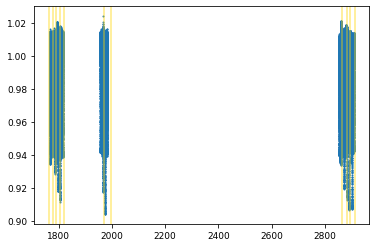

In [5]:
fig, ax = plt.subplots()

plt.scatter(alltime, allflux, s = 1)

period_9 = 9.9730
t0_9 = 1795.506 - (period_9 * 3)

#for i in range(0,120):
#    plt.axvline(t0_9 + (i*period_9), color = 'gold', alpha = 0.3)
#    
#for i in range(0,120):
#    plt.axvline(t0_9+(period_9/2) + (i*period_9), color = 'red', alpha = 0.3)
#    
for i in [1762, 1776.6, 1790.4, 1802.6, 1820, 1971.02, 1997.6, 2865.1, 2882.221, 2896.149, 2913.3]:
    plt.axvline(i, color = 'gold', alpha = 0.5)

(-0.1, 0.1)

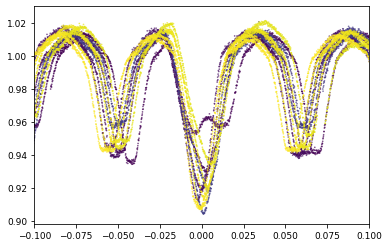

In [6]:
period_9 = 9.9728
t0_9 = 1795.506 - (period_9 * 3)

phased = np.array([-0.5+( ( t - t0_9-0.5*period_9) % period_9) / period_9 for t in alltime])

fig, ax = plt.subplots()

plt.scatter(phased,allflux, s = 0.5, alpha = 0.6, c = alltime)

plt.xlim(-0.1,0.1)

In [7]:
def sort_on_x(x,y):
    zipped = list(zip(x,y))
    zipped.sort(key=lambda x:x[0])
    x,y = list(zip(*zipped))
    return x,y


def run_binning(x,y,yerr=None,nbins=100,alias=False):
    # Binning function -- takes into account aliasing and error
    # propogation on errorbins
    bwidth = 1./nbins
    if alias==True:
        phStart,phStop = -0.6,0.6
    else:
        phStart,phStop = -0.5,0.5

    bins      = np.arange(phStart,phStop+bwidth,bwidth)
    bin_means = ( np.histogram(x,bins,weights=y)[0] / np.histogram(x,bins)[0] )
    if yerr is not None:
        bin_errs = ( np.histogram(x,bins,weights=yerr)[0] / np.histogram(x,bins)[0] )
    else:
        bin_errs = None

    return bwidth,bins,bin_means,bin_errs


def time_to_ph(time, period=1., t0=0., pshift=0.):
    '''
    converts time to phase from input ephemeris
    DOES NOT ACCOUNT FOR BARYCENTRIC OR HELIOCENTRIC CORRECTION

    input: time (float or array)  --> time point or array
    input: period (float)
    input: t0 (float)
    input: pshift (float) --> phase shift
    ------
    output: phase (float or array)
    '''
    time = np.array(time)
    ph = np.mod((time-t0)/period, 1.0) + pshift
    ph[ph < 0.0] += 1.
    ph[ph > 0.5] -= 1.

    return ph


def interpolate_signal(x_indep,x_model,y_model,nbins):

    
    bin_width,bin_edges,bin_means,_ = run_binning(x_model,y_model,nbins=nbins)
    
    mask = np.isfinite(bin_means) 

    bin_means = bin_means[mask]
    
    bins = bin_edges[:-1]+0.5*bin_width
    
    bins = bins[mask]
    interpolated_model = PchipInterpolator(bins,bin_means,extrapolate=False)
    interpolated_y = interpolated_model(x_indep)

    return interpolated_y,interpolated_model


def model_signal(period,t0,x,y,x1=None,y1=None,nbins=100):

    ph_x = time_to_ph(x,period,t0)
    ph_x_sorted,y_sorted = sort_on_x(ph_x,y)
    y_interpolated, model = interpolate_signal(ph_x,ph_x_sorted,y_sorted,nbins)

    y_model_subtracted = y-y_interpolated

    return y_model_subtracted, y_interpolated, model


def trend_removal_interact(period_a, t0_a, times_original, flux_original, time_cut, flux_cut):

    flux_cut_sub_period_a, flux_cut_period_a_model,\
    flux_cut_period_a_function = model_signal(period_a, t0_a,time_cut,flux_cut)
    
    ph_original = time_to_ph(times_original,period_a,t0_a)
    ph_cut = time_to_ph(time_cut,period_a,t0_a)
    
    flux_original_period_a_model = flux_cut_period_a_function(ph_original)
    flux_original_sub_period_a = flux_original - np.array(flux_original_period_a_model)
    
    fig,axes = plt.subplots(2,1, figsize = (7,8))
    fig.subplots_adjust(bottom=0.2)

    axes[0].plot(ph_original,flux_original,marker = '.', lw = 0, color = 'grey')
    axes[0].plot(ph_cut,flux_cut,marker = '.', lw = 0, color = 'k')
    
    axes[0].plot(ph_original,flux_original_period_a_model,marker = '.', lw = 0, color = 'darkorange', ms = 2)
    
    
    axes[1].plot(ph_original,flux_original_sub_period_a,'k.', alpha = 0.5)
    
    axes[0].set_ylabel(r'$Flux$',fontsize=18)
    axes[1].set_ylabel(r'$Flux$',fontsize=18)
    axes[1].set_xlabel(r'$\Phi$',fontsize=18)
    
    
    axes[0].tick_params(direction='in', length = 3, which ='minor', colors='grey', labelsize=13)
    axes[0].tick_params(axis="y",direction="inout") #, pad= -20)
    axes[0].tick_params(axis="x",direction="inout") #, pad= -17)   
    axes[0].tick_params(axis='both', length = 5, left='on', top='on', right='on', bottom='on')

    axes[1].tick_params(direction='in', length = 3, which ='minor', colors='grey', labelsize=13)
    axes[1].tick_params(axis="y",direction="inout") #, pad= -20)
    axes[1].tick_params(axis="x",direction="inout") #, pad= -17)   
    axes[1].tick_params(axis='both', length = 5, left='on', top='on', right='on', bottom='on')


    #plt.savefig('/Users/Nora/Documents/research/projects/fluffy/figs/sig_removal.png', dpi = 300)
    plt.show()  
    
    return ph_original,times_original, flux_original_sub_period_a, flux_original_period_a_model, ph_cut, flux_cut


In [8]:
data = {'time': search_result.time.value, 'flux': search_result.flux.value, 'err': search_result.flux_err.value}

time_cut_w9 = search_result.time.value
flux_cut_w9 = search_result.flux.value
err_cut_w9 = search_result.flux_err.value

#time_cut_w9 = data['time']
#flux_cut_w9 = data['flux']
#err_cut_w9 = data['err']

new_mask_w9 = (time_cut_w9 > 1790 ) & (time_cut_w9 < 1792) 
time_cut_w9 = time_cut_w9[~new_mask_w9]
flux_cut_w9 = flux_cut_w9[~new_mask_w9]
err_cut_w9 = err_cut_w9[~new_mask_w9]

new_mask_w9 = (time_cut_w9 > 1814 ) & (time_cut_w9 < 1815) 
time_cut_w9 = time_cut_w9[~new_mask_w9]
flux_cut_w9 = flux_cut_w9[~new_mask_w9]
err_cut_w9 = err_cut_w9[~new_mask_w9]


In [9]:

time_cut = time_cut_w9
flux_cut = flux_cut_w9
err_cut = err_cut_w9

for i in range(0,1030):
    
    mask = (time_cut > ((t0_9 + (i*period_9))-0.35)) & (time_cut < ((t0_9 + (i*period_9))+0.35))

    time_cut = time_cut[~mask]
    flux_cut = flux_cut[~mask]
    err_cut = err_cut[~mask]
    
new_mask = (time_cut > 1790 ) & (time_cut < 1792) 
time_cut = time_cut[~new_mask]
flux_cut = flux_cut[~new_mask]
err_cut = err_cut[~new_mask]

new_mask = (time_cut > 1814 ) & (time_cut < 1815) 
time_cut = time_cut[~new_mask]
flux_cut = flux_cut[~new_mask]
err_cut = err_cut[~new_mask]



period_a = period
t0_a = t0

good_mask = np.isfinite(np.array(data['time'])) * np.isfinite(np.array(data['flux'])) 

alltime_ar = np.array(data['time'])[good_mask]
allflux_ar = np.array(data['flux'])[good_mask]

good_mask_cut = np.isfinite(np.array(time_cut)) * np.isfinite(np.array(flux_cut)) 
good_mask_cut_w9 = np.isfinite(np.array(time_cut_w9)) * np.isfinite(np.array(flux_cut_w9)) 


alltime_ar_cut = np.array(time_cut)[good_mask_cut]
allflux_ar_cut = np.array(flux_cut)[good_mask_cut]

alltime_ar_cut_w9 = np.array(time_cut_w9)[good_mask_cut_w9]
allflux_ar_cut_w9 = np.array(flux_cut_w9)[good_mask_cut_w9]

#plt.scatter(time_cut_w9, flux_cut_w9, s = 1)



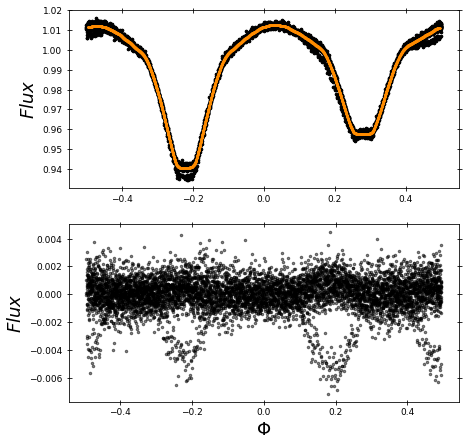

In [10]:
cut_times = [1762, 1776.6, 1790.4, 1802.6, 1820, 1971.02, 1997.6, 2865.1, 2882.221, 2896.149, 2913.3]
color = ['r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k']


    

#fig, ax = plt.subplots()
mask = (alltime_ar_cut > cut_times[section_number]) & (alltime_ar_cut < cut_times[section_number+1])
mask_w9 = (alltime_ar_cut_w9 > cut_times[section_number]) & (alltime_ar_cut_w9 < cut_times[section_number+1])


#plt.scatter(time_cut_w9[mask], flux_cut_w9[mask],s = 0.5)
#plt.show()
alltime_ar_cut_w9 = alltime_ar_cut_w9[mask_w9]
allflux_ar_cut_w9 = allflux_ar_cut_w9[mask_w9]

    
alltime_ar_cut = alltime_ar_cut[mask]
allflux_ar_cut = allflux_ar_cut[mask]



ph_original, times_original, flux_original_sub_period_a, model, ph_cut, flux_cut = trend_removal_interact(period_a, 0.1, alltime_ar_cut, allflux_ar_cut, alltime_ar_cut, allflux_ar_cut)
  
    
    


In [11]:

'''
cut_times = [1762, 1776.6, 1790.4, 1802.6, 1820, 1971.02, 1997.6, 2865.1, 2882.221, 2896.149, 2913.3]
color = ['r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k']

ph_original = []
times_original = []
flux_original_sub_period_a = []
model = []
ph_cut = []
flux_cut = []
    
for i in range(0,len(cut_times)-1):
    #fig, ax = plt.subplots()
    mask = (alltime_ar_cut > cut_times[i]) & (alltime_ar_cut < cut_times[i+1])
    mask_w9 = (alltime_ar_cut_w9 > cut_times[i]) & (alltime_ar_cut_w9 < cut_times[i+1])

    #plt.scatter(time_cut_w9[mask], flux_cut_w9[mask],s = 0.5)
    #plt.show()
    alltime_ar_cut_w9_temp = alltime_ar_cut_w9[mask_w9]
    allflux_ar_cut_w9_temp = allflux_ar_cut_w9[mask_w9]

    if len(alltime_ar_cut_w9_temp) == 0:
        continue
    alltime_ar_cut_temp = alltime_ar_cut[mask]
    allflux_ar_cut_temp = allflux_ar_cut[mask]

    period = 1.1047115
    t0 = 1766.267

    #phased = np.array([-0.5+( ( t - t0-0.5*period) % period) / period for t in alltime_ar_cut_temp])
    #
    #fig, ax = plt.subplots()
    #
    #plt.scatter(phased,allflux_ar_cut_temp, s = 2, alpha = 0.8, c = alltime_ar_cut_temp)
    #
    #plt.xlim(-0.15,0.15)
    
    ph_original_temp, times_original_temp, flux_original_sub_period_a_temp, model_temp, ph_cut_temp, flux_cut_temp = trend_removal_interact(period_a, 0.1, alltime_ar_cut_temp, allflux_ar_cut_temp, alltime_ar_cut_temp, allflux_ar_cut_temp)
    
    ph_original.append(ph_original_temp)
    times_original.append(times_original_temp)
    flux_original_sub_period_a.append(flux_original_sub_period_a_temp)
    model.append(model_temp)
    ph_cut.append(ph_cut_temp)
    flux_cut.append(flux_cut_temp)
    
    
    
ph_original = np.hstack(ph_original)
times_original = np.hstack(times_original)
flux_original_sub_period_a = np.hstack(flux_original_sub_period_a)
model = np.hstack(model)
ph_cut = np.hstack(ph_cut)
flux_cut = np.hstack(flux_cut)
'''

"\ncut_times = [1762, 1776.6, 1790.4, 1802.6, 1820, 1971.02, 1997.6, 2865.1, 2882.221, 2896.149, 2913.3]\ncolor = ['r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k']\n\nph_original = []\ntimes_original = []\nflux_original_sub_period_a = []\nmodel = []\nph_cut = []\nflux_cut = []\n    \nfor i in range(0,len(cut_times)-1):\n    #fig, ax = plt.subplots()\n    mask = (alltime_ar_cut > cut_times[i]) & (alltime_ar_cut < cut_times[i+1])\n    mask_w9 = (alltime_ar_cut_w9 > cut_times[i]) & (alltime_ar_cut_w9 < cut_times[i+1])\n\n    #plt.scatter(time_cut_w9[mask], flux_cut_w9[mask],s = 0.5)\n    #plt.show()\n    alltime_ar_cut_w9_temp = alltime_ar_cut_w9[mask_w9]\n    allflux_ar_cut_w9_temp = allflux_ar_cut_w9[mask_w9]\n\n    if len(alltime_ar_cut_w9_temp) == 0:\n        continue\n    alltime_ar_cut_temp = alltime_ar_cut[mask]\n    allflux_ar_cut_temp = allflux_ar_cut[mask]\n\n    period = 1.1047115\n    t0 = 1766.267\n\n    #phased = np.array([-0.5+( ( t - t0-0.5*period) 

In [12]:
flux_cut

array([0.97988725, 0.9813172 , 0.98211706, ..., 0.9831733 , 0.9812762 ,
       0.9823704 ], dtype=float32)

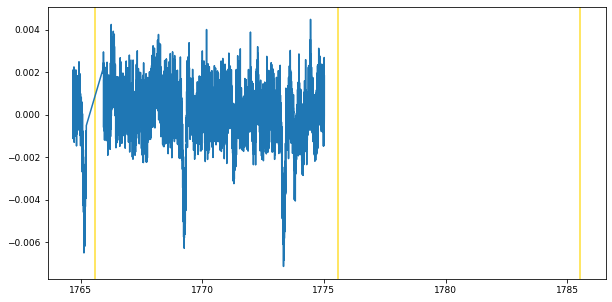

In [13]:
plt.figure(figsize=(10,5))

for i in range (0,3):

    plt.axvline(t0_9 + (i*period_9), alpha = 0.8, color = 'gold', zorder = -2)

plt.plot(times_original, flux_original_sub_period_a)

plt.show()

In [14]:
# Remove the overall trend and then re do the fitting to remoe the signal to see whether we can improve on the trend removal
import filters
import norm

times_cut = times_original
flux_cut = flux_original_sub_period_a

T_dur = 5

nmed = int(30*3*T_dur)
nmed = 2*int(nmed/2)+1


ff = filters.NIF(np.array(flux_cut),nmed,10,fill=True,verbose=True)

# first number is three times transit durations, the second quite small (10,20 )
l = np.isfinite(ff)



10 6743 451
reached the end
NIF: 0 0 -1 0.0010307232431951917
10 6521 451
reached the end
NIF: 1 302 0 0.0009788866155657063
10 6485 451
reached the end
NIF: 2 338 302 0.00097529615000659
10 6484 451
reached the end
NIF: 3 339 338 0.0009750141598585465
10 6484 451
reached the end
NIF: 4 339 339 0.0009750141598585465


6823 6823
10 6743 451
reached the end
NIF: 0 0 -1 0.0010307232431951917
10 6521 451
reached the end
NIF: 1 302 0 0.0009788866155657063
10 6485 451
reached the end
NIF: 2 338 302 0.00097529615000659
10 6484 451
reached the end
NIF: 3 339 338 0.0009750141598585465
10 6484 451
reached the end
NIF: 4 339 339 0.0009750141598585465


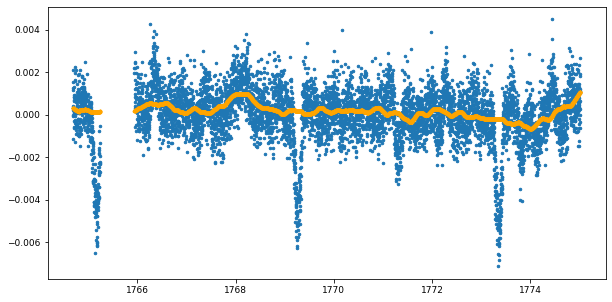

In [15]:
from scipy.interpolate import interp1d
g = interp1d(times_cut[l],ff[l],bounds_error=False,fill_value=np.nan)

ff = g(times_cut)
plt.figure(figsize=(10,5))
plt.plot(times_cut,flux_cut,'.')
plt.plot(times_cut,ff,'.', color = 'orange')
print(np.isfinite(ff).sum(),len(ff))


T_dur = 5

nmed = int(30*3*T_dur)
nmed = 2*int(nmed/2)+1


ff = filters.NIF(np.array(flux_cut),nmed,10,fill=True,verbose=True)

# first number is three times transit durations, the second quite small (10,20 )
l = np.isfinite(ff)

g = interp1d(times_cut[l],ff[l],bounds_error=False,fill_value=np.nan)

ff = g(times_original)


6823 6823


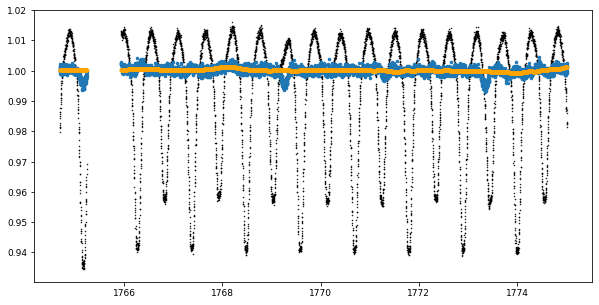

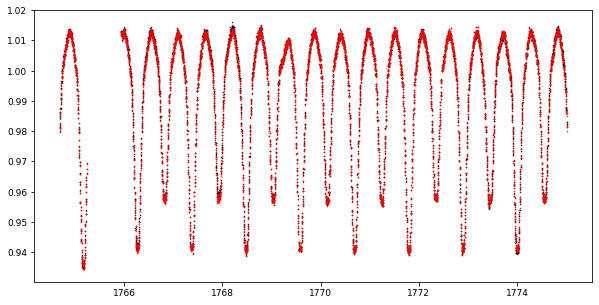

In [16]:
plt.figure(figsize=(10,5))

plt.plot(alltime_ar_cut,allflux_ar_cut,'.', color = 'k', ms = 1) 

print(np.isfinite(ff).sum(),len(ff))
plt.plot(times_cut,flux_cut+1,'.')
plt.plot(times_original,((ff*1.2)+1),'.', color = 'orange')

flux_detrended_sig_rem = allflux_ar_cut - (ff)
time_detrended_sig_rem = times_original

fig, ax = plt.subplots(figsize=(10,5))

plt.plot(alltime_ar_cut, allflux_ar_cut,'.k', ms = 1)
plt.plot(time_detrended_sig_rem, flux_detrended_sig_rem,'.r', alpha = 1, ms = 1)



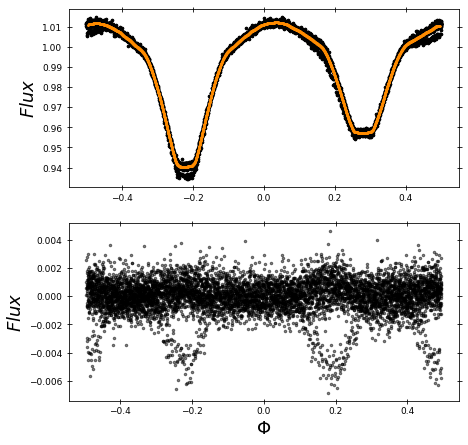

In [17]:
# now that it has been detrended, run the phase folding again:

ph_original, times_original, flux_original_sub_period_a, model, ph_cut, flux_cut = trend_removal_interact(period_a, 0.1, time_detrended_sig_rem, flux_detrended_sig_rem, time_detrended_sig_rem, flux_detrended_sig_rem)

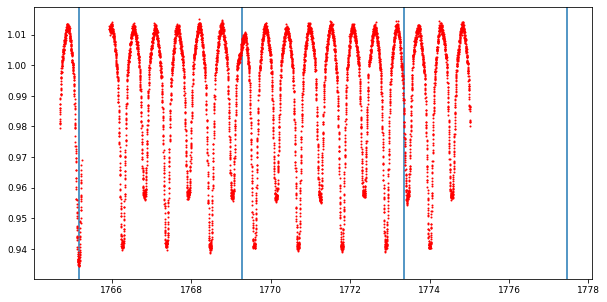

In [18]:
plt.figure(figsize=(10,5))

period_4 =  4.09175
t0_4 = 1765.185

for i in range(0,4):
    plt.axvline(t0_4 + (i*period_4))
plt.plot(time_detrended_sig_rem, flux_detrended_sig_rem,'.r', alpha = 1, ms = 2)

plt.show()

#np.savetxt("/Users/Nora/Documents/research/projects/fluffy/fluffy_removesig/LC_9d_removed.txt", np.array([time_detrended_sig_rem, flux_detrended_sig_rem]).T)

In [19]:
import statsmodels.api as sm


In [20]:
lowess = sm.nonparametric.lowess


In [21]:

#plt.plot(ph_original, model, lw = 0, marker = '.')   

model_smooth = lowess(model, ph_original,return_sorted = True, frac = 0.01, it = 5)

model_smooth_x = model_smooth[:,0]
model_smooth_y = model_smooth[:,1]

gradient = np.gradient(model_smooth_y, model_smooth_x)


In [22]:
gradient_smooth0 = lowess(gradient, model_smooth_x,return_sorted = True, frac = 0.01, it = 5)

gradient_smooth0_x = gradient_smooth0[:,0]
gradient_smooth0_y = gradient_smooth0[:,1]

gradient_smooth = lowess(gradient_smooth0_y, gradient_smooth0_x,return_sorted = True, frac = 0.01, it = 5)

gradient_smooth_x = gradient_smooth[:,0]
gradient_smooth_y = gradient_smooth[:,1]


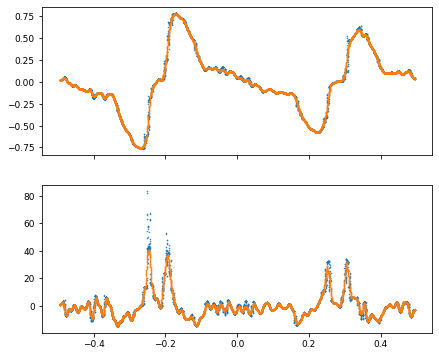

In [23]:
fig,ax = plt.subplots(2,1, figsize = (7,6), sharex = True)

ax[0].plot(model_smooth_x, gradient, lw = 0, marker = '.', ms = 1)
ax[0].plot(gradient_smooth_x, gradient_smooth_y, lw = 0, marker = '.', ms = 1)

derif2 = np.gradient(gradient_smooth_y, gradient_smooth_x)

derif2_smooth = lowess(derif2, gradient_smooth_x, return_sorted = True, frac = 0.01, it = 5)

derif2_smooth_x = derif2_smooth[:,0]
derif2_smooth_y = derif2_smooth[:,1]

ax[1].plot(gradient_smooth_x, derif2, lw = 0, marker = '.', ms = 1)
ax[1].plot(derif2_smooth_x, derif2_smooth_y, lw = 0, marker = '.', ms = 1)

plt.show()

In [24]:
#def model_fit(x, alpha0, alpha1, t0, d, Tau):
#    
#    cosh_term = np.cosh( (x - t0) /d )
#    exp_term = np.exp(1 - cosh_term)
#    pow_term = pow((1 - exp_term), Tau)
#    
#    psi = 1 - pow_term
#    
#    model = alpha0 + (alpha1 * psi)
#    
#    return model 

In [25]:
import yaml
import emcee

In [26]:
def log_prior(theta):
    amp, t0, width,slope = theta
    
    # amp, t0, width, slope
    # -0.044, 0.257, 0.049222498391319536, -0.55
    

    if  (-1 < amp < 0) and ( -0.5 < t0 < 0.5) and (0 < width < 1) and (-1 < slope < 0):
        return 0.0


    return -np.inf


def log_likelihood(theta, x, y, yerr):
    
    amp, t0, width, slope   = theta
    
    t_init = models.Trapezoid1D(amplitude=amp, x_0=t0, width=width, slope=slope)
    model = t_init(x)
    
    return -0.5 * np.sum((y - model) ** 2 / (yerr ** 2) )


def log_probability(theta, x, y, yerr):
    
    # check that the priors are satisfied
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


def get_starting_positions(start_vals, nwalkers=128):

    p0 = np.array( [ [ val+1e-5*np.random.randn()
                       for jj,val in enumerate(start_vals) ]
                      for i in range(nwalkers) ] )
    
    yield p0


In [27]:
np.median(err_cut)

print(-0.365 + 0.0275 + 0.01)
print(-0.0863-0.032 - 0.01)

-0.32749999999999996
-0.1283


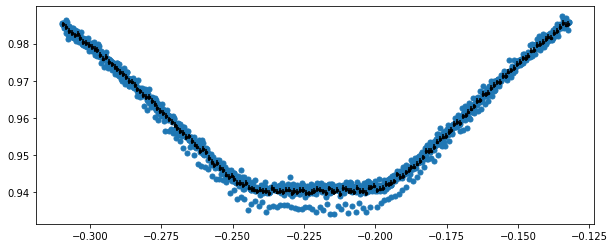

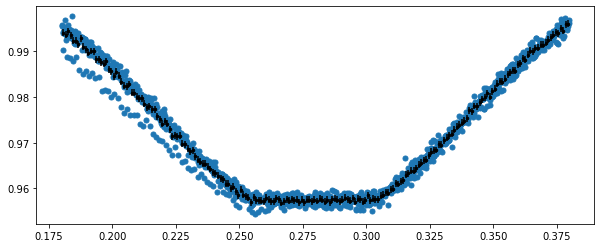

In [54]:
# for primary 
def prepare_data_elcipse(time, phase, flux, err, start_ph, end_ph):

    df = pd.DataFrame({'time':time,'phase':phase, 'flux':flux, 'err':err})

    df_in_phase = df[(df['phase'] > start_ph) & (df['phase'] < end_ph) ]

    return df_in_phase


df_in_phase_primary = prepare_data_elcipse(times_original, ph_cut, flux_cut, len(flux_cut) * [0.00076063], -0.31, -0.132)#-0.315, -0.0863)        
df_in_phase_secondary = prepare_data_elcipse(times_original, ph_cut, flux_cut, len(flux_cut) * [0.00076063], 0.18,0.38) #-0.315, -0.0863)        

ph_primary0  = df_in_phase_primary.phase
flux_primary0 = df_in_phase_primary.flux
err_primary0 = df_in_phase_primary.err

ph_secondary0  = df_in_phase_secondary.phase
flux_secondary0 = df_in_phase_secondary.flux
err_secondary0 = df_in_phase_secondary.err


def run_binning(x,y,period=1.,yerr=None,nbins=100):
    # Binning function -- takes into account aliasing and error
    # propogation on errorbins
    
    bwidth = 1./nbins
    phStart,phStop = np.nanmin(x), np.nanmax(x)

    bins      = np.arange(phStart,phStop+bwidth,bwidth)
    bin_means = ( np.histogram(x,bins,weights=y)[0] / np.histogram(x,bins)[0] )
    if yerr is not None:
        bin_errs = ( np.histogram(x,bins,weights=yerr)[0] / np.histogram(x,bins)[0] )
    else:
        bin_errs = None
    
    bins =  bins[:-1] + 0.5*bwidth
    
    return bins,bin_means,bin_errs


ph_binned,flux_binned,err_binned = run_binning(ph_primary0,flux_primary0,period=1.,yerr=err_primary0,nbins=1000)
ph_binned_s,flux_binned_s,err_binned_s = run_binning(ph_secondary0,flux_secondary0,period=1.,yerr=err_secondary0,nbins=1000)


fig = plt.subplots(figsize=(10, 4), sharex=True)

plt.errorbar(ph_binned, flux_binned, yerr=err_binned, fmt=".k", capsize=0, zorder = 2)
plt.scatter(ph_primary0, flux_primary0, zorder = -2)

ph_primary =   ph_primary0 #ph_binned #ph_primary0 ph_binned
flux_primary = flux_primary0 -1 #flux_binned - 1 #flux_primary0 flux_binned
err_primary = err_primary0 #err_binned #err_primary0 err_binned

plt.show()

# -- -- -- -- -- -- -- -- -- 
fig = plt.subplots(figsize=(10, 4), sharex=True)

plt.errorbar(ph_binned_s, flux_binned_s, yerr=err_binned_s, fmt=".k", capsize=0, zorder = 2)
plt.scatter(ph_secondary0, flux_secondary0, zorder = -2)

ph_secondary =   ph_secondary0 #ph_binned #ph_primary0 ph_binned
flux_secondary = flux_secondary0 -1 #flux_binned - 1 #flux_primary0 flux_binned
err_secondary = err_secondary0 #err_binned #err_primary0 err_binned
 

plt.show()

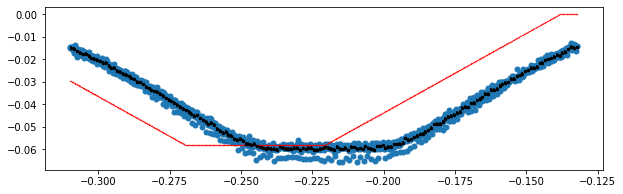

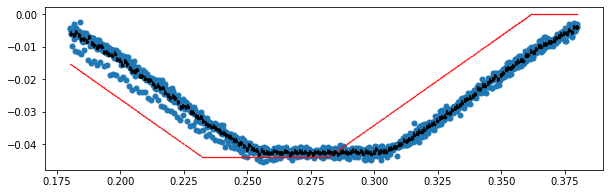

In [55]:
# alpha0 + alpha1 * (1 - ( 1 - np.exp( 1 - np.cosh( (x - t0)/ d ))))**Tau 

#def model_fit(x, alpha0, alpha1, t0, d, Tau):
#    
#    cosh_term = np.cosh( (x - t0) /d )
#    exp_term = np.exp(1 - cosh_term)
#    pow_term = pow((1 - exp_term), Tau)
#    
#    psi = 1 - pow_term
#    
#    model = alpha0 + (alpha1 * psi)
#    
#    return model 

def model_fit(x, amp, t0, width, slope):

    t_init = models.Trapezoid1D(amplitude=amp, x_0=t0, width=width, slope=slope)

    return t_init(x)


fig = plt.subplots(figsize=(10, 3), sharex=True)

#alpha0, alpha1, t0, d, Tau

plt.errorbar(ph_binned, flux_binned-1, yerr=err_binned, fmt=".k", capsize=0, zorder = 2)
plt.scatter(ph_primary0, flux_primary0-1, zorder = -2)

#amp, t0, width, slope

plt.plot(ph_primary0, model_fit(ph_primary0, -0.05787605317820328, -0.245, 0.049222498391319536, -0.7044735219536102), lw = 0, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')


fig = plt.subplots(figsize=(10, 3), sharex=True)

#alpha0, alpha1, t0, d, Tau

plt.errorbar(ph_binned_s, flux_binned_s-1, yerr=err_binned_s, fmt=".k", capsize=0, zorder = 2)
plt.scatter(ph_secondary0, flux_secondary0-1, zorder = -2)
plt.plot(ph_secondary0, model_fit(ph_secondary0, -0.044, 0.257, 0.049222498391319536, -0.55), lw = 0, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')


In [56]:
start_vals = [-0.05787605317820328, -0.245, 0.049222498391319536, -0.7044735219536102]
start_vals_s = [-0.044, 0.257, 0.049222498391319536, -0.55]

pos = list(get_starting_positions(start_vals,nwalkers=128))[0]
pos_s = list(get_starting_positions(start_vals_s,nwalkers=128))[0]

nwalkers = 128
ndim = len(start_vals)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ph_primary, flux_primary, err_primary))
sampler_s = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ph_secondary, flux_secondary, err_secondary))

sampler.run_mcmc(pos, 1000, progress=True)
sampler_s.run_mcmc(pos_s, 1000, progress=True)

 10%|████▏                                   | 105/1000 [00:04<00:41, 21.65it/s]Traceback (most recent call last):
  File "/Users/neisner/opt/anaconda3/envs/main/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/cq/dyd07h4n7wl_x1s67x4snjx40000gq/T/ipykernel_11486/2496891493.py", line 31, in log_probability
    return lp + log_likelihood(theta, x, y, yerr)
  File "/var/folders/cq/dyd07h4n7wl_x1s67x4snjx40000gq/T/ipykernel_11486/2496891493.py", line 22, in log_likelihood
    return -0.5 * np.sum((y - model) ** 2 / (yerr ** 2) )
  File "/Users/neisner/opt/anaconda3/envs/main/lib/python3.9/site-packages/pandas/core/ops/common.py", line 81, in new_method
    return method(self, other)
  File "/Users/neisner/opt/anaconda3/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py", line 210, in __truediv__
    return self._arith_method(other, operator.truediv)
  File "/Users/neisner/opt/anaconda3/env

emcee: Exception while calling your likelihood function:
  params: [-0.05904825 -0.22117864  0.04848797 -0.69986428]
  args: (272    -0.308782
273    -0.307525
274    -0.306268
275    -0.305011
276    -0.303753
          ...   
6818   -0.306724
6819   -0.305467
6820   -0.304209
6821   -0.302952
6822   -0.301695
Name: phase, Length: 1242, dtype: float64, 272    -0.015811
273    -0.018869
274    -0.017437
275    -0.019273
276    -0.019469
          ...   
6818   -0.018187
6819   -0.018644
6820   -0.017898
6821   -0.019799
6822   -0.018710
Name: flux, Length: 1242, dtype: float64, 272     0.000761
273     0.000761
274     0.000761
275     0.000761
276     0.000761
          ...   
6818    0.000761
6819    0.000761
6820    0.000761
6821    0.000761
6822    0.000761
Name: err, Length: 1242, dtype: float64)
  kwargs: {}
  exception:



KeyboardInterrupt



In [ ]:
tau = sampler.get_autocorr_time(tol=0)
print (tau)
tau_s = sampler_s.get_autocorr_time(tol=0)
print (tau_s)

In [ ]:
samples = sampler.get_chain()
labels = ['amp', 'x_0', 'width', 'slope']

for i in range(ndim):
    fig, axes = plt.subplots(figsize=(10, 3))
    plt.plot(samples[:, :, i], "k", alpha=0.3)
    #ax.set_xlim(0, len(samples))
    #plt.ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)
    plt.show()
    
samples_s = sampler_s.get_chain()
labels = ['amp', 'x_0', 'width', 'slope']

for i in range(ndim):
    fig, axes = plt.subplots(figsize=(10, 3))
    plt.plot(samples_s[:, :, i], "k", alpha=0.3)
    #ax.set_xlim(0, len(samples))
    #axes.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)
    plt.show()

In [33]:
flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)
print(flat_samples.shape)
flat_samples_s = sampler_s.get_chain(discard=600, thin=15, flat=True)
print(flat_samples_s.shape)

(3328, 4)
(3328, 4)


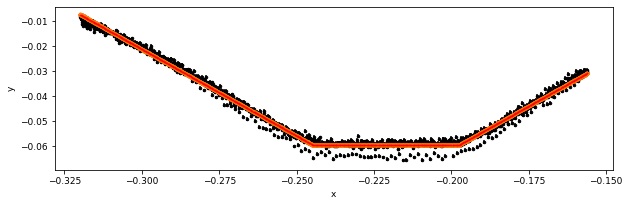

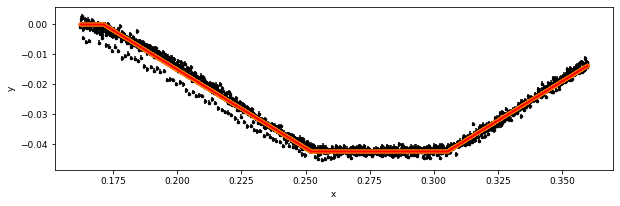

In [34]:
fig = plt.subplots(figsize=(10, 3), sharex=True)

mean_amp = np.median(flat_samples[:,0])
mean_t0 = np.median(flat_samples[:,1])
mean_width = np.median(flat_samples[:,2])
mean_slope = np.median(flat_samples[:,3])

#plt.plot(ph_secondary0, model_fit(ph_secondary0, 0.985, -0.03, 0.3, 0.035, 1.9), lw = 0, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')
#x, alpha0, alpha1, t0, d, Tau



inds = np.random.randint(len(flat_samples), size=100)

for ind in inds:
    sample = flat_samples[ind]
    
    model = model_fit(ph_primary, sample[0], sample[1], sample[2], sample[3])
    plt.plot(ph_primary, model, "C1", lw = 0, marker = '.',alpha=0.1, zorder = 2)
    
    
plt.errorbar(ph_primary, flux_primary, yerr=err_primary, fmt=".k", capsize=0, zorder = -2)

model_mean = model_fit(ph_primary, mean_amp, mean_t0, mean_width, mean_slope)
plt.plot(ph_primary, model_mean, lw = 0, marker = '.', markersize = 1, alpha=1, zorder = 2, color= 'red')

plt.xlabel("x")
plt.ylabel("y");

plt.show()

# ----  ----  ---- ----

fig = plt.subplots(figsize=(10, 3), sharex=True)

mean_amp_s = np.median(flat_samples_s[:,0])
mean_t0_s = np.median(flat_samples_s[:,1])
mean_width_s = np.median(flat_samples_s[:,2])
mean_slope_s = np.median(flat_samples_s[:,3])


inds_s = np.random.randint(len(flat_samples_s), size=100)

for ind in inds_s:
    sample_s = flat_samples_s[ind]
    
    model = model_fit(ph_secondary, sample_s[0], sample_s[1], sample_s[2], sample_s[3])
    plt.plot(ph_secondary, model, "C1", lw = 0, marker = '.',alpha=0.1, zorder = 2)
    


plt.errorbar(ph_secondary, flux_secondary, yerr=err_secondary, fmt=".k", capsize=0, zorder = -2)

model_mean = model_fit(ph_secondary, mean_amp_s, mean_t0_s, mean_width_s, mean_slope_s)
plt.plot(ph_secondary, model_mean, lw = 0, marker = '.', markersize = 1, alpha=1, zorder = 2, color= 'red')

plt.xlabel("x")
plt.ylabel("y");

plt.show()

In [ ]:


def log_prior_fitting(theta):
    t0, offset = theta
    
    if  (-0.5 < t0 < 0.5) and (-1 < offset < 2):
        return 0.0
    return -np.inf


def log_likelihood_fitting(theta, x, y, yerr):
    
    t0, offset  = theta
    
    t_init = models.Trapezoid1D(amplitude=mean_amp, x_0=t0, width=mean_width, slope=mean_slope)
    model = t_init(x) + offset
    
    return -0.5 * np.sum((y - model) ** 2 / (yerr ** 2) )


def log_probability_fitting(theta, x, y, yerr):
    
    # check that the priors are satisfied
    lp = log_prior_fitting(theta)
    if not np.isfinite(lp):
        return -np.inf
    lnp = lp + log_likelihood_fitting(theta, x, y, yerr)

    return lnp


def log_likelihood_fitting_s(theta, x, y, yerr):
    
    t0, offset  = theta
    
    t_init = models.Trapezoid1D(amplitude=mean_amp_s, x_0=t0, width=mean_width_s, slope=mean_slope_s)
    model = t_init(x) + offset
    
    return -0.5 * np.sum((y - model) ** 2 / (yerr ** 2) )


def log_probability_fitting_s(theta, x, y, yerr):
    
    # check that the priors are satisfied
    lp = log_prior_fitting(theta)
    if not np.isfinite(lp):
        return -np.inf
    lnp = lp + log_likelihood_fitting_s(theta, x, y, yerr)

    return lnp

def get_starting_positions_fitting(start_vals, nwalkers=64):

    p0 = np.array( [ [ val+1e-5*np.random.randn()
                       for jj,val in enumerate(start_vals) ]
                      for i in range(nwalkers) ] )
    
    yield p0



In [ ]:
time_primary  = df_in_phase_primary.time
ph_primary  = df_in_phase_primary.phase
flux_primary = df_in_phase_primary.flux - 1
err_primary = df_in_phase_primary.err

time_secondary  = df_in_phase_secondary.time
ph_secondary  = df_in_phase_secondary.phase
flux_secondary = df_in_phase_secondary.flux - 1
err_secondary = df_in_phase_secondary.err


In [ ]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(time_secondary,flux_secondary , s = 1)
plt.scatter(time_primary,flux_primary , s = 1)

for i in range (0,55):

    plt.axvline(t0_9 + (i*period_9), alpha = 0.8, color = 'gold', zorder = -2)
    #plt.axvline(t0_4 + (i*period_4), alpha = 0.8, color = 'grey', zorder = -2)

    plt.xlim(1750,1990)
plt.show()


plt.show()

Creating new manifest file
Creating new manifest file


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 87.66it/s]


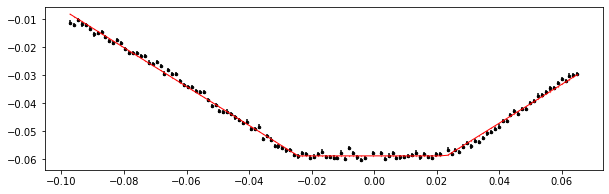

100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 87.16it/s]


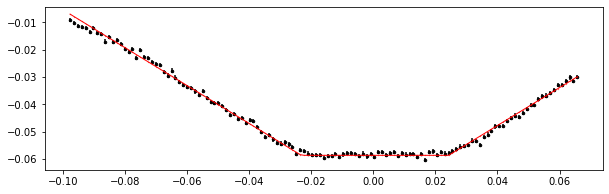

100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 87.86it/s]


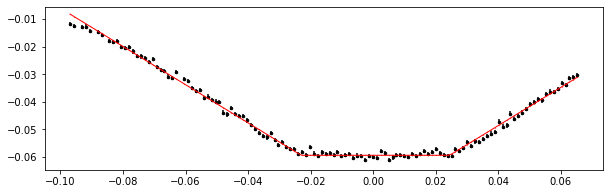

100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 88.22it/s]


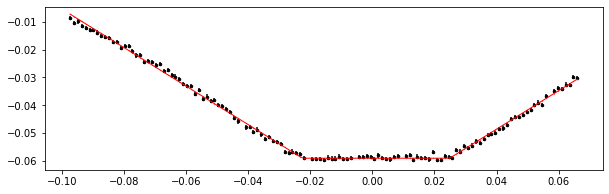

 69%|███████████████████████████▌            | 688/1000 [00:07<00:03, 85.60it/s]Traceback (most recent call last):
  File "/Users/neisner/opt/anaconda3/envs/main/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/cq/dyd07h4n7wl_x1s67x4snjx40000gq/T/ipykernel_11486/1170865141.py", line 25, in log_probability_fitting
    lnp = lp + log_likelihood_fitting(theta, x, y, yerr)
  File "/var/folders/cq/dyd07h4n7wl_x1s67x4snjx40000gq/T/ipykernel_11486/1170865141.py", line 14, in log_likelihood_fitting
    model = t_init(x) + offset
  File "/Users/neisner/opt/anaconda3/envs/main/lib/python3.9/site-packages/astropy/modeling/core.py", line 424, in __call__
    new_call = make_function_with_signature(
  File "/Users/neisner/opt/anaconda3/envs/main/lib/python3.9/site-packages/astropy/modeling/core.py", line 401, in __call__
    return super(cls, self).__call__(*inputs, **kwargs)
  File "/Users/neisner/opt/anacond

emcee: Exception while calling your likelihood function:
  params: [0.00146022 0.00029353]
  args: (array([-0.09787065, -0.09661338, -0.09535611, -0.09409884, -0.09284158,
       -0.09158431, -0.09032704, -0.08906977, -0.0878125 , -0.08655523,
       -0.08529796, -0.08404069, -0.08278342, -0.08152615, -0.08026888,
       -0.07901161, -0.07775434, -0.07649707, -0.0752398 , -0.07398253,
       -0.07272526, -0.07146799, -0.07021072, -0.06895345, -0.06769619,
       -0.06643892, -0.06518165, -0.06392438, -0.06266711, -0.06140984,
       -0.06015257, -0.0588953 , -0.05763803, -0.05638076, -0.05512349,
       -0.05386622, -0.05260895, -0.05135168, -0.05009441, -0.04883714,
       -0.04757987, -0.0463226 , -0.04506533, -0.04380807, -0.0425508 ,
       -0.04129353, -0.04003626, -0.03877899, -0.03752172, -0.03626445,
       -0.03500718, -0.03374991, -0.03249264, -0.03123537, -0.0299781 ,
       -0.02872083, -0.02746356, -0.02620629, -0.02494902, -0.02369175,
       -0.02243448, -0.02117722, -0.


KeyboardInterrupt



In [38]:
%matplotlib inline 
from os.path import basename, exists
import sys 
import csv

tr_index = range(0, 10096)

t0_primary = t0
t0_secondary = t0 - (period/2)

outfile_path = '/Users/neisner/Documents/projects/fluffy/reanalysed/mcmc_etvs_primary_section{}_orig_period.csv'.format(section_number+1)
outfile_path_s = '/Users/neisner/Documents/projects/fluffy/reanalysed/mcmc_etvs_secondary_section{}_orig_period.csv'.format(section_number+1)

if exists('{}'.format(outfile_path)):
    print("Existing manifest file found, will skip previously processed LCs and append to end of manifest file")
    sys.stdout.flush()


else:
    print("Creating new manifest file")
    sys.stdout.flush()
    metadata_header = ["number", 'epoch', 't0', 'amp', 'width', 'slope', 'offset', 'stdv']
       
    with open('{}'.format(outfile_path), 'w') as f: # save in the photometry folder
        writer = csv.writer(f, delimiter=',')
        writer.writerow(metadata_header)

# - - - - - - - - - - 

if exists('{}'.format(outfile_path_s)):
    print("Existing manifest file found, will skip previously processed LCs and append to end of manifest file")
    sys.stdout.flush()


else:
    print("Creating new manifest file")
    sys.stdout.flush()
    metadata_header = ["number", 'epoch', 't0', 'amp', 'width', 'slope', 'offset', 'stdv']
       
    with open('{}'.format(outfile_path_s), 'w') as f: # save in the photometry folder
        writer = csv.writer(f, delimiter=',')
        writer.writerow(metadata_header)

        
manifest_table = pd.read_csv('{}'.format(outfile_path))
manifest_table_s = pd.read_csv('{}'.format(outfile_path_s))

number_done = manifest_table['number']
number_done_s = manifest_table_s['number']
            
for i in tr_index:
    if not np.isin(i,number_done):
        
        transit_time = t0_primary+(period*i)
        
        x = np.array(time_primary)
        y = np.array(flux_primary)
        yerr = np.array(err_primary)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])
        
        x = np.array([-0.5+( ( t - t0_primary-0.5*period) % period) / period for t in x])
        
        if len(x) > 20:
            # starting vals
            start_vals = [0,0]
            
            pos = list(get_starting_positions(start_vals,nwalkers=64))[0]
            
            nwalkers = 64
            ndim = len(start_vals)
            
            # start the mcmc fitting
            sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_fitting, args=(x, y, yerr))
            
            sampler2.run_mcmc(pos, 1000, progress=True)
    
            flat_samples2 = sampler2.get_chain(discard=200, thin=15, flat=True)
            
            mean_t0_fit = np.nanmedian(flat_samples2[:,0])
            stdv_t0_fit = np.nanstd(flat_samples2[:,0])
            mean_offset_fit = np.nanmedian(flat_samples2[:,1])
    
            fig = plt.subplots(figsize=(10, 3), sharex=True)
            
            plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, zorder = -2)

            t_init = models.Trapezoid1D(amplitude=mean_amp, x_0=mean_t0_fit, width=mean_width, slope=mean_slope)
            model_mean = t_init(x) + mean_offset_fit

            plt.plot(x, model_mean, lw = 1, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')
    
            plt.show()
              
              
            with open('{}'.format(outfile_path), 'a') as f: # save in the photometry folder
                writer = csv.writer(f, delimiter=',')
                writer.writerow([i, transit_time, mean_t0_fit, mean_amp, mean_width, mean_slope, mean_offset_fit, stdv_t0_fit])
        else:  
            print ("not enough data -- skip")
    else:
        print ("Number {} has already been completed -- skip".format(i))
        
# - - - - - - - - - - - - - 

print (" ________ -------- {}".format(number_done_s))
for i in tr_index:
    print (i)
    if not np.isin(i,number_done_s):
        
        transit_time = t0_secondary+(period*i)
        
        x = np.array(time_secondary)
        y = np.array(flux_secondary)
        yerr = np.array(err_secondary)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])
        
        x = np.array([-0.5+( ( t - t0_secondary-0.5*period) % period) / period for t in x])
        
        if len(x) > 20:
            # starting vals
            start_vals = [0,0]
            
            pos = list(get_starting_positions(start_vals,nwalkers=64))[0]
            
            nwalkers = 64
            ndim = len(start_vals)
            
            # start the mcmc fitting
            sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_fitting_s, args=(x, y, yerr))
            
            sampler2.run_mcmc(pos, 1000, progress=True)
    
            flat_samples2 = sampler2.get_chain(discard=200, thin=15, flat=True)
            

            mean_t0_fit_s = np.nanmedian(flat_samples2[:,0])
            stdv_t0_fit_s = np.nanstd(flat_samples2[:,0])
            mean_offset_fit_s = np.nanmedian(flat_samples2[:,1])
    
            
            fig = plt.subplots(figsize=(10, 3), sharex=True)
            
            plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, zorder = -2)

            t_init = models.Trapezoid1D(amplitude=mean_amp_s, x_0=mean_t0_fit_s, width=mean_width_s, slope=mean_slope_s)
            model_mean = t_init(x) + mean_offset_fit_s

            plt.plot(x, model_mean, lw = 1, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')
    
            plt.show()
              
            with open('{}'.format(outfile_path_s), 'a') as f: # save in the photometry folder
                writer = csv.writer(f, delimiter=',')
                writer.writerow([i, transit_time, mean_t0_fit_s, mean_amp_s, mean_width_s, mean_slope_s, mean_slope_s, stdv_t0_fit_s])
        else:  
            continue
    else:
        continue

In [ ]:
#in_df_binned = pd.read_csv('/Users/Nora/Documents/research/projects/fluffy/fluffy_etvs/mcmc_etvs_binned.csv')

#in_df_4d = pd.read_csv('/Users/Nora/Documents/research/projects/fluffy/fluffy_etvs/mcmc_etvs_4d.csv')


In [ ]:
%matplotlib notebook

fig = plt.subplots(figsize=(10, 3), sharex=True)

for sec_num in [1,2,3,4,5,6,7,8,9]:
    
    in_df_primary = pd.read_csv('/Users/neisner/Documents/projects/fluffy/reanalysed/mcmc_etvs_primary_section{}_orig_period.csv'.format(sec_num +1))
    in_df_secondary = pd.read_csv('/Users/neisner/Documents/projects/fluffy/reanalysed/mcmc_etvs_secondary_section{}_orig_period.csv'.format(sec_num +1))
    
    in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
    in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
    in_df_primary['std_mins'] = in_df_primary['stdv']*period*24*60
    
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv']*period*24*60
    
    #in_df_4d['midpoint'] = in_df_4d['epoch'] + (in_df_4d['t0']*period)
    #in_df_4d['shift_mins'] = in_df_4d['t0']*period*24*60
    
    
    
    plt.errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
                 lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', markeredgecolor = 'crimson')
    plt.errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2 )
    
    #plt.errorbar(in_df_4d['epoch'], in_df_4d['shift_mins'], lw = 0, marker = '.', elinewidth = 1 )
    

#period_9 = 9.9733
#t0_9 = 1785.532657 - (period_9*3)

period_4 = 4.0919
t0_4 = 1769.27


#for i in range (0,55):
#
#    #plt.axvline(t0_9 + (i*period_9), alpha = 0.8, color = 'gold', zorder = -2)
#    plt.axvline(t0_4 + (i*period_4), alpha = 0.8, color = 'grey', zorder = -2)
#
plt.ylim(-10,10)

plt.axhline(4.5)
plt.axhline(-2.16)
plt.xlabel("Time (BJD)", fontsize = 18)
plt.ylabel("O - C (minutes)", fontsize = 18)
plt.show()

